<a href="https://colab.research.google.com/github/alexmrin/Image-deep-learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import CIFAR10
from sklearn.metrics import accuracy_score
import torchvision.utils as vutils
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [28]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [29]:
data = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
train_dataset, valid_dataset = random_split(data, [.9, .1])
test_dataset = CIFAR10(root='./data', train=False, transform=test_transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [30]:
resnet_18 = models.resnet18(pretrained=True)
features = nn.Sequential(*list(resnet_18.children())[:-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
class transfer_resnet(nn.Module):
  def __init__(self, num_classes, features):
    super().__init__()
    self.features = features
    self.fc = nn.Sequential(
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    features = self.features(x)
    fc = torch.flatten(features, start_dim=1)
    output = self.fc(fc)
    return output

In [32]:
model = transfer_resnet(10, features)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_losses = []
valid_losses = []

def train_loop():
  model.train()
  running_loss = 0
  all_pred = []
  all_label = []
  for images, labels, in tqdm(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    pred = model(images)
    all_pred.extend(pred.argmax(dim=1).detach().cpu().numpy())
    all_label.extend(labels.cpu().numpy())
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f'Train acc: {accuracy_score(all_label, all_pred)}')
  train_losses.append(running_loss/len(train_dataset))

def valid_loop():
  model.eval()
  running_loss = 0
  all_pred = []
  all_label = []
  with torch.no_grad():
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)
      pred = model(images)
      all_pred.extend(pred.argmax(dim=1).detach().cpu().numpy())
      all_label.extend(labels.cpu().numpy())
      loss = criterion(pred, labels)
      running_loss += loss.item()

  print(f'validation acc: {accuracy_score(all_label, all_pred)}')
  valid_losses.append(running_loss/len(valid_dataset))

100%|██████████| 704/704 [00:36<00:00, 19.55it/s]


Train acc: 0.19455555555555556
validation acc: 0.2018
epoch: 1/100 | train loss: 0.043075162471665276 | valid loss: 0.03386245603561401


100%|██████████| 704/704 [00:38<00:00, 18.40it/s]


Train acc: 0.3222888888888889
validation acc: 0.32
epoch: 2/100 | train loss: 0.028146752744250828 | valid loss: 0.029544081830978394


100%|██████████| 704/704 [00:36<00:00, 19.54it/s]


Train acc: 0.39968888888888887
validation acc: 0.4128
epoch: 3/100 | train loss: 0.025266845809088813 | valid loss: 0.027818693113327027


100%|██████████| 704/704 [00:36<00:00, 19.18it/s]


Train acc: 0.4592888888888889
validation acc: 0.4766
epoch: 4/100 | train loss: 0.023028896851009794 | valid loss: 0.023010300731658936


100%|██████████| 704/704 [00:36<00:00, 19.29it/s]


Train acc: 0.5104444444444445
validation acc: 0.4952
epoch: 5/100 | train loss: 0.021302168034182653 | valid loss: 0.021957528018951417


100%|██████████| 704/704 [00:36<00:00, 19.20it/s]


Train acc: 0.5481555555555555
validation acc: 0.4904
epoch: 6/100 | train loss: 0.019862854577435387 | valid loss: 0.024076166892051696


100%|██████████| 704/704 [00:37<00:00, 18.98it/s]


Train acc: 0.5666444444444444
validation acc: 0.5366
epoch: 7/100 | train loss: 0.019138620585865445 | valid loss: 0.02073878252506256


100%|██████████| 704/704 [00:37<00:00, 18.99it/s]


Train acc: 0.5890888888888889
validation acc: 0.5724
epoch: 8/100 | train loss: 0.018338706636428833 | valid loss: 0.0194436292052269


100%|██████████| 704/704 [00:34<00:00, 20.21it/s]


Train acc: 0.6022444444444445
validation acc: 0.5462
epoch: 9/100 | train loss: 0.017776457142829896 | valid loss: 0.020291119575500487


100%|██████████| 704/704 [00:35<00:00, 19.64it/s]


Train acc: 0.6091333333333333
validation acc: 0.5878
epoch: 10/100 | train loss: 0.017379542590512168 | valid loss: 0.01930222865343094


100%|██████████| 704/704 [00:34<00:00, 20.44it/s]


Train acc: 0.6224666666666666
validation acc: 0.551
epoch: 11/100 | train loss: 0.016916528403759002 | valid loss: 0.020536952197551726


100%|██████████| 704/704 [00:34<00:00, 20.12it/s]


Train acc: 0.6276444444444444
validation acc: 0.5786
epoch: 12/100 | train loss: 0.016571699870957267 | valid loss: 0.018625322616100313


100%|██████████| 704/704 [00:34<00:00, 20.65it/s]


Train acc: 0.6336888888888889
validation acc: 0.6148
epoch: 13/100 | train loss: 0.01636480567985111 | valid loss: 0.017567141950130462


100%|██████████| 704/704 [00:33<00:00, 20.79it/s]


Train acc: 0.6391777777777777
validation acc: 0.6204
epoch: 14/100 | train loss: 0.016209878146648406 | valid loss: 0.01764925366640091


100%|██████████| 704/704 [00:35<00:00, 19.97it/s]


Train acc: 0.6480444444444444
validation acc: 0.633
epoch: 15/100 | train loss: 0.015869724309444427 | valid loss: 0.016454460966587068


100%|██████████| 704/704 [00:34<00:00, 20.20it/s]


Train acc: 0.6567555555555555
validation acc: 0.531
epoch: 16/100 | train loss: 0.015584812337822385 | valid loss: 0.021715068113803863


100%|██████████| 704/704 [00:33<00:00, 20.99it/s]


Train acc: 0.6561333333333333
validation acc: 0.6066
epoch: 17/100 | train loss: 0.015619391844007704 | valid loss: 0.018287929034233093


100%|██████████| 704/704 [00:34<00:00, 20.32it/s]


Train acc: 0.6622666666666667
validation acc: 0.642
epoch: 18/100 | train loss: 0.015372242601712546 | valid loss: 0.01672413372993469


100%|██████████| 704/704 [00:36<00:00, 19.43it/s]


Train acc: 0.6657333333333333
validation acc: 0.658
epoch: 19/100 | train loss: 0.015131543535656398 | valid loss: 0.015657299971580507


100%|██████████| 704/704 [00:35<00:00, 19.62it/s]


Train acc: 0.6668444444444445
validation acc: 0.59
epoch: 20/100 | train loss: 0.015000065779685974 | valid loss: 0.019150027060508727


100%|██████████| 704/704 [00:33<00:00, 20.88it/s]


Train acc: 0.6685111111111111
validation acc: 0.624
epoch: 21/100 | train loss: 0.014997296630011665 | valid loss: 0.017304350781440735


100%|██████████| 704/704 [00:33<00:00, 20.73it/s]


Train acc: 0.6729555555555555
validation acc: 0.6634
epoch: 22/100 | train loss: 0.014856231405999926 | valid loss: 0.01582124357223511


100%|██████████| 704/704 [00:35<00:00, 20.06it/s]


Train acc: 0.6774666666666667
validation acc: 0.6594
epoch: 23/100 | train loss: 0.014741188465224372 | valid loss: 0.01561859423518181


100%|██████████| 704/704 [00:34<00:00, 20.30it/s]


Train acc: 0.6779555555555555
validation acc: 0.649
epoch: 24/100 | train loss: 0.01465581841468811 | valid loss: 0.015876555562019348


100%|██████████| 704/704 [00:33<00:00, 20.90it/s]


Train acc: 0.6810222222222222
validation acc: 0.654
epoch: 25/100 | train loss: 0.014633321678638457 | valid loss: 0.016222371912002563


100%|██████████| 704/704 [00:34<00:00, 20.19it/s]


Train acc: 0.6777777777777778
validation acc: 0.629
epoch: 26/100 | train loss: 0.014622181014882194 | valid loss: 0.016718853175640105


100%|██████████| 704/704 [00:35<00:00, 20.10it/s]


Train acc: 0.6827777777777778
validation acc: 0.642
epoch: 27/100 | train loss: 0.014437387319405874 | valid loss: 0.01621965460777283


100%|██████████| 704/704 [00:33<00:00, 20.84it/s]


Train acc: 0.6847777777777778
validation acc: 0.6632
epoch: 28/100 | train loss: 0.014473873680167728 | valid loss: 0.016112006640434266


100%|██████████| 704/704 [00:35<00:00, 20.11it/s]


Train acc: 0.6842666666666667
validation acc: 0.6822
epoch: 29/100 | train loss: 0.01441303614113066 | valid loss: 0.014787571680545807


100%|██████████| 704/704 [00:37<00:00, 18.99it/s]


Train acc: 0.6847777777777778
validation acc: 0.6916
epoch: 30/100 | train loss: 0.014436662802431319 | valid loss: 0.014261364030838013


100%|██████████| 704/704 [00:35<00:00, 19.84it/s]


Train acc: 0.7685333333333333
validation acc: 0.7786
epoch: 31/100 | train loss: 0.010547027883927028 | valid loss: 0.01017304791212082


100%|██████████| 704/704 [00:34<00:00, 20.28it/s]


Train acc: 0.7907111111111111
validation acc: 0.7854
epoch: 32/100 | train loss: 0.009507097842295965 | valid loss: 0.009686775833368301


100%|██████████| 704/704 [00:34<00:00, 20.59it/s]


Train acc: 0.7988444444444445
validation acc: 0.7876
epoch: 33/100 | train loss: 0.009110454774565168 | valid loss: 0.009743185991048812


100%|██████████| 704/704 [00:34<00:00, 20.20it/s]


Train acc: 0.8086
validation acc: 0.785
epoch: 34/100 | train loss: 0.008764968323045307 | valid loss: 0.009603549134731293


100%|██████████| 704/704 [00:35<00:00, 19.94it/s]


Train acc: 0.8107333333333333
validation acc: 0.7934
epoch: 35/100 | train loss: 0.008600401508808137 | valid loss: 0.009359301066398621


100%|██████████| 704/704 [00:34<00:00, 20.61it/s]


Train acc: 0.8134888888888889
validation acc: 0.7904
epoch: 36/100 | train loss: 0.00842102172308498 | valid loss: 0.009664499908685684


100%|██████████| 704/704 [00:33<00:00, 20.72it/s]


Train acc: 0.8207555555555556
validation acc: 0.7982
epoch: 37/100 | train loss: 0.00813988965815968 | valid loss: 0.009191589492559432


100%|██████████| 704/704 [00:35<00:00, 20.08it/s]


Train acc: 0.8188666666666666
validation acc: 0.8026
epoch: 38/100 | train loss: 0.008090592294269137 | valid loss: 0.009080487141013146


100%|██████████| 704/704 [00:34<00:00, 20.45it/s]


Train acc: 0.8231111111111111
validation acc: 0.7988
epoch: 39/100 | train loss: 0.00795426439775361 | valid loss: 0.009294549131393432


100%|██████████| 704/704 [00:34<00:00, 20.40it/s]


Train acc: 0.8261333333333334
validation acc: 0.8076
epoch: 40/100 | train loss: 0.007874497479200363 | valid loss: 0.009237845402956009


100%|██████████| 704/704 [00:34<00:00, 20.48it/s]


Train acc: 0.8259777777777778
validation acc: 0.7952
epoch: 41/100 | train loss: 0.007846623571713765 | valid loss: 0.009405029422044754


100%|██████████| 704/704 [00:34<00:00, 20.13it/s]


Train acc: 0.8285555555555556
validation acc: 0.797
epoch: 42/100 | train loss: 0.0077774047238959206 | valid loss: 0.009329514545202255


100%|██████████| 704/704 [00:34<00:00, 20.47it/s]


Train acc: 0.8305111111111111
validation acc: 0.7926
epoch: 43/100 | train loss: 0.0077171378430393005 | valid loss: 0.009514761620759964


100%|██████████| 704/704 [00:34<00:00, 20.68it/s]


Train acc: 0.8303333333333334
validation acc: 0.8112
epoch: 44/100 | train loss: 0.007649422347214487 | valid loss: 0.008926019674539567


100%|██████████| 704/704 [00:35<00:00, 20.05it/s]


Train acc: 0.8321111111111111
validation acc: 0.8032
epoch: 45/100 | train loss: 0.0076336369434992475 | valid loss: 0.009082677701115607


100%|██████████| 704/704 [00:35<00:00, 20.02it/s]


Train acc: 0.8342222222222222
validation acc: 0.8084
epoch: 46/100 | train loss: 0.007486767346660296 | valid loss: 0.008944301682710648


100%|██████████| 704/704 [00:34<00:00, 20.66it/s]


Train acc: 0.8352666666666667
validation acc: 0.7966
epoch: 47/100 | train loss: 0.00748714005847772 | valid loss: 0.009402735233306885


100%|██████████| 704/704 [00:34<00:00, 20.48it/s]


Train acc: 0.8353111111111111
validation acc: 0.8078
epoch: 48/100 | train loss: 0.007459285733766026 | valid loss: 0.009132665252685548


100%|██████████| 704/704 [00:35<00:00, 19.89it/s]


Train acc: 0.8316444444444444
validation acc: 0.8026
epoch: 49/100 | train loss: 0.007572279423806403 | valid loss: 0.009480938810110091


100%|██████████| 704/704 [00:34<00:00, 20.19it/s]


Train acc: 0.8357555555555556
validation acc: 0.8046
epoch: 50/100 | train loss: 0.007404593169689179 | valid loss: 0.008958001059293747


100%|██████████| 704/704 [00:34<00:00, 20.45it/s]


Train acc: 0.8374888888888888
validation acc: 0.8064
epoch: 51/100 | train loss: 0.007345448107851876 | valid loss: 0.00903275328874588


100%|██████████| 704/704 [00:33<00:00, 21.17it/s]


Train acc: 0.8375555555555556
validation acc: 0.7938
epoch: 52/100 | train loss: 0.007363400583465894 | valid loss: 0.009648784202337266


100%|██████████| 704/704 [00:33<00:00, 20.99it/s]


Train acc: 0.8361111111111111
validation acc: 0.8092
epoch: 53/100 | train loss: 0.007371532389852736 | valid loss: 0.008995413678884507


100%|██████████| 704/704 [00:33<00:00, 20.71it/s]


Train acc: 0.8390666666666666
validation acc: 0.7934
epoch: 54/100 | train loss: 0.007259562034739388 | valid loss: 0.00981068185567856


100%|██████████| 704/704 [00:34<00:00, 20.52it/s]


Train acc: 0.8368888888888889
validation acc: 0.7962
epoch: 55/100 | train loss: 0.007402746017111672 | valid loss: 0.009268991285562515


100%|██████████| 704/704 [00:34<00:00, 20.37it/s]


Train acc: 0.8405111111111111
validation acc: 0.781
epoch: 56/100 | train loss: 0.007237632054752773 | valid loss: 0.010170851922035217


100%|██████████| 704/704 [00:34<00:00, 20.57it/s]


Train acc: 0.8398666666666667
validation acc: 0.7896
epoch: 57/100 | train loss: 0.007301988842421107 | valid loss: 0.009661479026079178


100%|██████████| 704/704 [00:33<00:00, 20.84it/s]


Train acc: 0.8387333333333333
validation acc: 0.7962
epoch: 58/100 | train loss: 0.007234543851017952 | valid loss: 0.009535670775175094


100%|██████████| 704/704 [00:33<00:00, 21.18it/s]


Train acc: 0.8447111111111111
validation acc: 0.7938
epoch: 59/100 | train loss: 0.00708108922806051 | valid loss: 0.009721308046579362


100%|██████████| 704/704 [00:33<00:00, 20.86it/s]


Train acc: 0.8438666666666667
validation acc: 0.7912
epoch: 60/100 | train loss: 0.007098020787040393 | valid loss: 0.009612911093235015


100%|██████████| 704/704 [00:34<00:00, 20.25it/s]


Train acc: 0.8756666666666667
validation acc: 0.8436
epoch: 61/100 | train loss: 0.005661519160204464 | valid loss: 0.007353042751550675


100%|██████████| 704/704 [00:34<00:00, 20.44it/s]


Train acc: 0.8889111111111111
validation acc: 0.8434
epoch: 62/100 | train loss: 0.005078541340927283 | valid loss: 0.0073468598335981366


100%|██████████| 704/704 [00:34<00:00, 20.48it/s]


Train acc: 0.8928888888888888
validation acc: 0.8462
epoch: 63/100 | train loss: 0.004894785434669919 | valid loss: 0.0075536783307790754


100%|██████████| 704/704 [00:34<00:00, 20.47it/s]


Train acc: 0.8967555555555555
validation acc: 0.848
epoch: 64/100 | train loss: 0.00471394190473689 | valid loss: 0.007138766565918922


100%|██████████| 704/704 [00:33<00:00, 20.93it/s]


Train acc: 0.8978888888888888
validation acc: 0.848
epoch: 65/100 | train loss: 0.004635884988307953 | valid loss: 0.007377150395512581


100%|██████████| 704/704 [00:33<00:00, 21.05it/s]


Train acc: 0.9014888888888889
validation acc: 0.8464
epoch: 66/100 | train loss: 0.004516497830715445 | valid loss: 0.007284594219923019


100%|██████████| 704/704 [00:34<00:00, 20.65it/s]


Train acc: 0.9055333333333333
validation acc: 0.8414
epoch: 67/100 | train loss: 0.0043355442287193405 | valid loss: 0.007393475478887558


100%|██████████| 704/704 [00:34<00:00, 20.69it/s]


Train acc: 0.9071111111111111
validation acc: 0.8498
epoch: 68/100 | train loss: 0.004268321184979545 | valid loss: 0.007091953834891319


100%|██████████| 704/704 [00:34<00:00, 20.64it/s]


Train acc: 0.9070888888888888
validation acc: 0.8408
epoch: 69/100 | train loss: 0.00423338412311342 | valid loss: 0.007330121693015099


100%|██████████| 704/704 [00:34<00:00, 20.55it/s]


Train acc: 0.9096666666666666
validation acc: 0.8478
epoch: 70/100 | train loss: 0.0040920598748657435 | valid loss: 0.007332246007025242


100%|██████████| 704/704 [00:34<00:00, 20.67it/s]


Train acc: 0.9088666666666667
validation acc: 0.8468
epoch: 71/100 | train loss: 0.0041583361080951165 | valid loss: 0.00727998883575201


100%|██████████| 704/704 [00:33<00:00, 20.91it/s]


Train acc: 0.9122444444444444
validation acc: 0.845
epoch: 72/100 | train loss: 0.004046492267151674 | valid loss: 0.0073027762994170185


100%|██████████| 704/704 [00:33<00:00, 20.80it/s]


Train acc: 0.9133777777777777
validation acc: 0.853
epoch: 73/100 | train loss: 0.003944324374364482 | valid loss: 0.007247527939081192


100%|██████████| 704/704 [00:34<00:00, 20.38it/s]


Train acc: 0.9131111111111111
validation acc: 0.8456
epoch: 74/100 | train loss: 0.003920573268002934 | valid loss: 0.00755272031724453


100%|██████████| 704/704 [00:34<00:00, 20.41it/s]


Train acc: 0.9156444444444445
validation acc: 0.8552
epoch: 75/100 | train loss: 0.0038305173797739877 | valid loss: 0.0071743351176381115


100%|██████████| 704/704 [00:34<00:00, 20.28it/s]


Train acc: 0.915
validation acc: 0.8436
epoch: 76/100 | train loss: 0.003842988760272662 | valid loss: 0.007454315959662199


100%|██████████| 704/704 [00:34<00:00, 20.28it/s]


Train acc: 0.9176888888888889
validation acc: 0.8526
epoch: 77/100 | train loss: 0.00373921973299649 | valid loss: 0.00708486687541008


100%|██████████| 704/704 [00:34<00:00, 20.49it/s]


Train acc: 0.9149777777777778
validation acc: 0.8456
epoch: 78/100 | train loss: 0.003777184585150745 | valid loss: 0.007455367720127106


100%|██████████| 704/704 [00:33<00:00, 20.84it/s]


Train acc: 0.9200666666666667
validation acc: 0.8514
epoch: 79/100 | train loss: 0.0036345017208821244 | valid loss: 0.0074719079494476315


100%|██████████| 704/704 [00:34<00:00, 20.62it/s]


Train acc: 0.9182444444444444
validation acc: 0.8498
epoch: 80/100 | train loss: 0.0036202027445866 | valid loss: 0.007274154976010323


100%|██████████| 704/704 [00:34<00:00, 20.57it/s]


Train acc: 0.9215333333333333
validation acc: 0.8488
epoch: 81/100 | train loss: 0.003575319439007176 | valid loss: 0.00736451977789402


100%|██████████| 704/704 [00:34<00:00, 20.27it/s]


Train acc: 0.9205111111111111
validation acc: 0.8468
epoch: 82/100 | train loss: 0.003565444943143262 | valid loss: 0.007321716663241386


100%|██████████| 704/704 [00:35<00:00, 20.01it/s]


Train acc: 0.9222444444444444
validation acc: 0.8458
epoch: 83/100 | train loss: 0.0034991107610364753 | valid loss: 0.007860231870412827


100%|██████████| 704/704 [00:34<00:00, 20.20it/s]


Train acc: 0.9231555555555555
validation acc: 0.8476
epoch: 84/100 | train loss: 0.0034568000442451903 | valid loss: 0.007567711350321769


100%|██████████| 704/704 [00:34<00:00, 20.13it/s]


Train acc: 0.9224
validation acc: 0.8572
epoch: 85/100 | train loss: 0.0035071513386236296 | valid loss: 0.007130785566568374


100%|██████████| 704/704 [00:34<00:00, 20.27it/s]


Train acc: 0.9255111111111111
validation acc: 0.8466
epoch: 86/100 | train loss: 0.0033847759387559363 | valid loss: 0.007527119892835617


100%|██████████| 704/704 [00:34<00:00, 20.27it/s]


Train acc: 0.9240888888888888
validation acc: 0.845
epoch: 87/100 | train loss: 0.0034096424689723384 | valid loss: 0.007642946353554726


100%|██████████| 704/704 [00:34<00:00, 20.13it/s]


Train acc: 0.9258888888888889
validation acc: 0.8512
epoch: 88/100 | train loss: 0.0032983031883835794 | valid loss: 0.007349485915899277


100%|██████████| 704/704 [00:33<00:00, 20.87it/s]


Train acc: 0.9278222222222222
validation acc: 0.8436
epoch: 89/100 | train loss: 0.0032429989867740205 | valid loss: 0.007701339906454086


100%|██████████| 704/704 [00:33<00:00, 20.80it/s]


Train acc: 0.9298444444444445
validation acc: 0.851
epoch: 90/100 | train loss: 0.0031896870878007676 | valid loss: 0.0076346023589372635


100%|██████████| 704/704 [00:35<00:00, 20.02it/s]


Train acc: 0.9336888888888889
validation acc: 0.8506
epoch: 91/100 | train loss: 0.0029984870142406887 | valid loss: 0.007523191675543785


100%|██████████| 704/704 [00:34<00:00, 20.20it/s]


Train acc: 0.9345111111111111
validation acc: 0.846
epoch: 92/100 | train loss: 0.002998613223599063 | valid loss: 0.007784713330864906


100%|██████████| 704/704 [00:34<00:00, 20.13it/s]


Train acc: 0.9351555555555555
validation acc: 0.8526
epoch: 93/100 | train loss: 0.002895696273032162 | valid loss: 0.0073802334994077685


100%|██████████| 704/704 [00:35<00:00, 20.06it/s]


Train acc: 0.9368666666666666
validation acc: 0.8506
epoch: 94/100 | train loss: 0.002874857529418336 | valid loss: 0.007488245551288128


100%|██████████| 704/704 [00:34<00:00, 20.46it/s]


Train acc: 0.9365333333333333
validation acc: 0.8568
epoch: 95/100 | train loss: 0.0028649702297316657 | valid loss: 0.007382862973213195


100%|██████████| 704/704 [00:33<00:00, 20.75it/s]


Train acc: 0.9372888888888888
validation acc: 0.857
epoch: 96/100 | train loss: 0.002849463490396738 | valid loss: 0.007384256473183632


100%|██████████| 704/704 [00:33<00:00, 20.99it/s]


Train acc: 0.9373111111111111
validation acc: 0.8534
epoch: 97/100 | train loss: 0.0028740222375012105 | valid loss: 0.007323607785999775


100%|██████████| 704/704 [00:33<00:00, 20.94it/s]


Train acc: 0.9382444444444444
validation acc: 0.8566
epoch: 98/100 | train loss: 0.002856780789958106 | valid loss: 0.007431347936391831


100%|██████████| 704/704 [00:34<00:00, 20.22it/s]


Train acc: 0.9384444444444444
validation acc: 0.8524
epoch: 99/100 | train loss: 0.00282302768793371 | valid loss: 0.007457963219285011


100%|██████████| 704/704 [00:34<00:00, 20.34it/s]


Train acc: 0.9405111111111111
validation acc: 0.8554
epoch: 100/100 | train loss: 0.002711213618227177 | valid loss: 0.007400193354487419


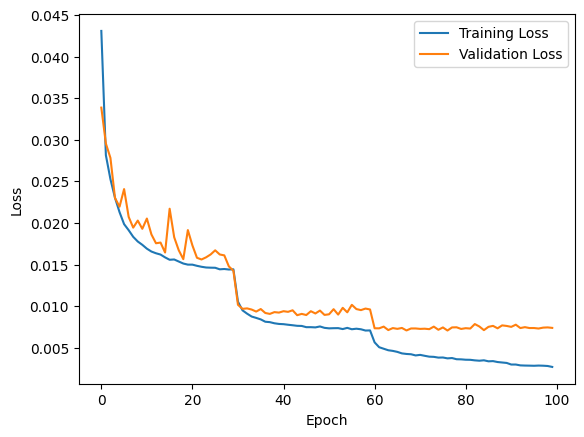

In [33]:
for epoch in range(num_epochs):
  train_loop()
  valid_loop()
  scheduler.step()
  print(f"epoch: {epoch+1}/{num_epochs} | train loss: {train_losses[epoch]} | valid loss: {valid_losses[epoch]}")

plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(train_losses, label='Training Loss')
sns.lineplot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()

In [35]:
all_pred = []
all_label = []
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)

  pred = model(images)
  pred = torch.argmax(pred, dim=1)
  all_pred.extend(pred.detach().cpu().numpy())
  all_label.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_label, all_pred)
print(f'test accuracy: {test_acc}')

test accuracy: 0.8547


In [36]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Image Classification/Convnet/transfer_resnet.pth')